Applying GenomeDISCO on Hi-C data
===

Analysis to produce Figure 1B, and Figure 3

Contact: oursu@stanford.edu

**3.2 Benchmarking GenomeDISCO on Hi-C datasets**

We used more than 80 high quality Hi-C datasets from (Rao et al., 2014) spanning multiple human cell-lines (GM12878, HMEC, HUVEC, IMR90, K562, KBM7, NHEK) to benchmark the behavior of our concordance score (Figure 3). Due to the lack of explicit ground truth about the nature of noise in real datasets, we evaluate the validity of the concordance score by expecting higher scores when comparing pairs of biological replicates of Hi-C data with similar distance-dependence characteristics as compared to scores obtained by comparing Hi-C datasets from different cell types. We focused our analysis on a subset of experiments defined as those done with in-situ Hi-C (see Supplementary Table 2).

Next, we used GenomeDISCO, HiCRep and HiC-Spector to compute concordance scores for all the pairs of biological replicates and pairs of samples from different cell types. Hierarchical clustering of the samples based on the matrix of all pairwise concordance scores revealed that samples from the same cell type cluster together, for all three methods (see Supplementary Figure 5). For each method we defined an empirical threshold for classifying sample-pairs into one of two categories labeled high-concordance and low-concordance. The threshold was determined as the highest score across all pairs of samples from different cell types, since we expect concordant biological replicates to be at least as con- cordant as samples from different cell types. We then analyzed the similarities and differences between the three methods in terms of their classification of the pairs of biological replicates. (Figure 3A). 

Out of 149 pairs of biological replicates in the test set, we found that the methods agreed across most samples (93/149 biological replicate pairs were classified consistently between GenomeDISCO and HiCRep, and 103/149 between GenomeDISCO and HiC-Spector). For a small subset of replicate-pairs, HiCRep and/or HiC-Spector classified them as high-concordance, while GenomeDISCO classified them as low concordance. For 27/56 of the discrepancies between Genome-DISCO and HiCRep and 19/46 of the discrepancies with HiC-Spector, the comparisons involved samples with large differences in distance dependence curves (difference in distance dependence curve higher than 0.005, a value that was found to distinguish pairs of biological replicates in the high-concordance class from those in the low concordance class). For example, samples HIC070 and HIC072 (biological replicates for the K562 cell line) are classified as low-concordance by GenomeDISCO (score 0.643), but classified as high-concordance by HiCRep (score 0.911). These samples have a marked difference in their distance dependence curves (ranked as the largest difference in distance dependence curve among all biological replicate pairs) (Figure 3C). In fact, GenomeDISCO scores in general drop proportional to the difference in distance dependence curves between the pair of samples being compared (Figure 3B). Finally, we find 16 cases ranked as non-concordant by both HiCRep and HiC-Spector but deemed concordant by GenomeDISCO. For 5/16 of these, the GenomeDISCO score is equal to the threshold concordance of 0.8. Similarly, there are 19 cases deemed concordant only by HiCRep and 7 deemed concordant only by HiC-Spector. 

We also found that 18 replicate pairs were deemed low-concordance by all three methods. In particular, in eight of these cases, replicate pairs classified as low-concordance by all three methods despite being deeply sequenced (>100 million reads) involved sample HIC014 from the GM12878 cell type (specifically HIC014 vs any of HIC004, HIC006, HIC010, HIC018, HIC022, HIC038, HIC042, HIC048). Upon closer inspection, we found that HIC014 exhibited an unusual pattern of uneven coverage across the genome (Figure 3D), likely explaining the observed results. 

Finally, we also used the Hi-C data to check whether GenomeDISCO is able to detect differences in protocols or restriction enzymes used for each experiment (see Supplementary Figure 4A). We found that GenomeDISCO scores are lower for comparisons between samples prepared with dilution Hi-C versus in situ Hi-C. This observation is expected because dilution Hi-C experiments capture more random ligations between nuclear and mitochondrial DNA than in-situ Hi-C (see (Rao et al., 2014)). We also found that GenomeDISCO scores are higher for experiments performed with the same enzyme, compared to different enzymes (Supplementary Figure 4B).

In [1]:
require(ggplot2)
require(pheatmap)
require(PRROC)
require(ggplot2)
niceggplot=theme(panel.border = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text=element_text(size=20),axis.title=element_text(size=20))+theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

Loading required package: ggplot2
Loading required package: pheatmap
Loading required package: PRROC


Parameters set in stone.

In [2]:
DATA_PATH='/ifs/scratch/oursu/paper_2017-12-20'
RES='50000'
SCORES_PATH=paste(DATA_PATH,'/results/rao/res',RES,'.final/compiled_scores',sep='')
PLOTS_PATH=paste(SCORES_PATH,'/plots',sep='')
system(paste('mkdir -p ',PLOTS_PATH))
DISTDEP_FILE=paste(DATA_PATH,'/results/rao/dd/dddiff.real.txt',sep='')

Divide datasets into training and test based on whether their dataset index is odd or even

In [3]:
metadata=read.table(paste(DATA_PATH,'/data/LA_metadata.txt',sep=''),header=TRUE,sep='\t')
rownames(metadata)=metadata[,'library']

train_data=metadata[seq(1,dim(metadata)[1],2),]
test_data=metadata[seq(2,dim(metadata)[1],2),]
print('Number of datasets in training set')
print(dim(train_data)[1])
print('Number of datasets in test set')
print(dim(test_data)[1])

[1] "Number of datasets in training set"
[1] 44
[1] "Number of datasets in test set"
[1] 43


Read in scores, for each time step, *t*, for GenomeDISCO

In [4]:
read_in_scores=function(f){
    scores=read.table(f)
    colnames(scores)[1:4]=c('chromosome','m1','m2','score')
    #remove comparisons comparing one dataset to itself
    same=which(as.character(scores[,2])==as.character(scores[,3]))
    if (length(same)>0){
        scores=scores[-same,]
    }
    rownames(scores)=paste(as.character(scores[,2]),as.character(scores[,3]))
    return(scores[,-1])
}

disco_by_t=read_in_scores(paste(SCORES_PATH,'/HiC.GenomeDISCO.scores.multiple_t.genomewide.txt.gz',sep=''))
colnames(disco_by_t)=c('m1','m2','1','2','3','4','5')
head(disco_by_t)

,m1,m2,1,2,3,4,5
HIC048 HIC066,HIC048,HIC066,0.15282609,0.5796957,0.6792174,0.7167826,0.7424783
HIC048 HIC064,HIC048,HIC064,0.04478261,0.5217826,0.6287391,0.6799130,0.7174783
HIC012 HIC026,HIC012,HIC026,0.20791304,0.7697391,0.8634783,0.8895652,0.9016087
HIC048 HIC062,HIC048,HIC062,-0.06617391,0.3366522,0.5795217,0.6675217,0.7153043
HIC048 HIC060,HIC048,HIC060,-0.09117391,0.3093478,0.5642609,0.6568696,0.7071304
HIC048 HIC068,HIC048,HIC068,0.02052174,0.4820870,0.5798696,0.6274348,0.6646087


**Finding the optimal value of *t*** (Figure 1B)

Obtain auPRC and auROC curves as a function of the parameter *t*

[1] "Training set performance ============================="
  t     auPRC
1 1 0.4575498
2 2 0.8430601
3 3 0.9605889
4 4 0.9634034
5 5 0.9575416
  t     auROC
1 1 0.6542259
2 2 0.8985076
3 3 0.9689963
4 4 0.9718838
5 5 0.9698116


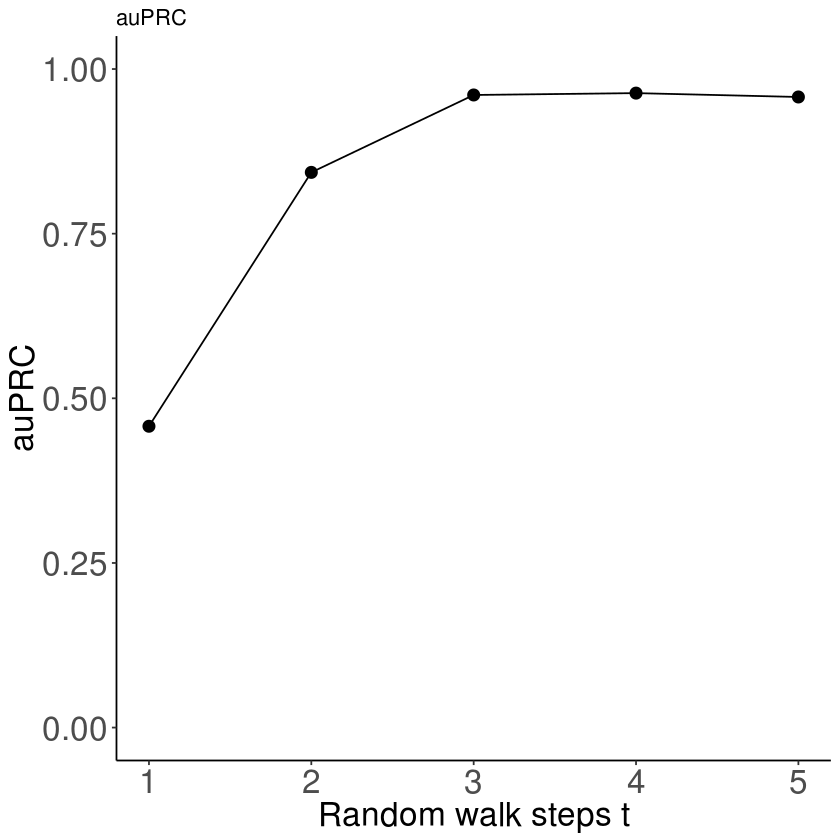

[1] "Test set performance ============================="
  t     auPRC
1 1 0.4116131
2 2 0.8256656
3 3 0.9252585
4 4 0.9349572
5 5 0.9339472


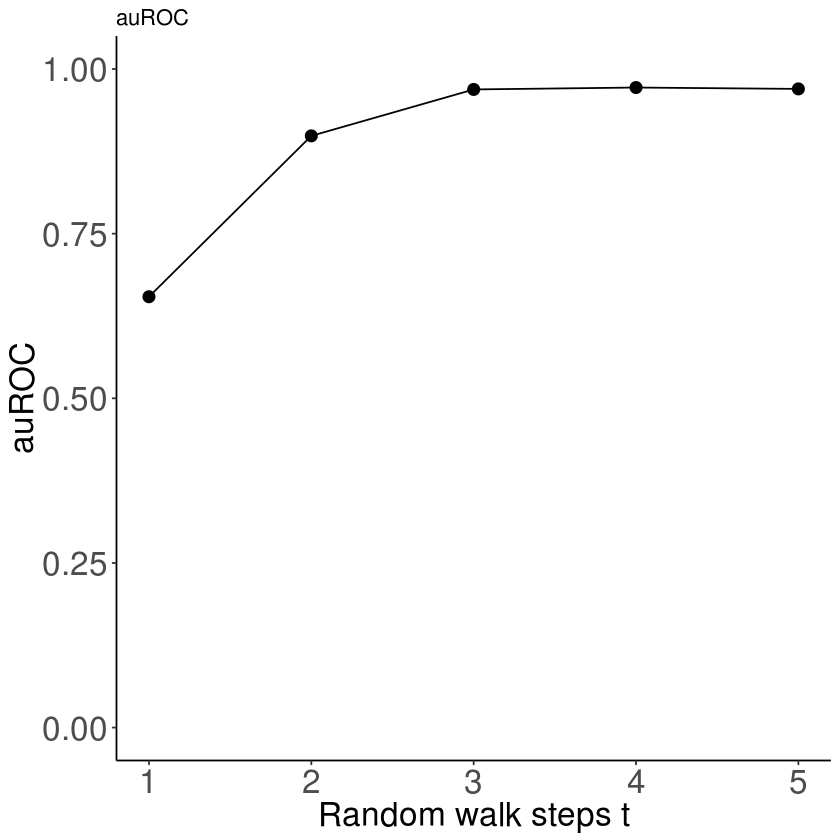

  t     auROC
1 1 0.6224301
2 2 0.8735770
3 3 0.9431442
4 4 0.9499724
5 5 0.9484326


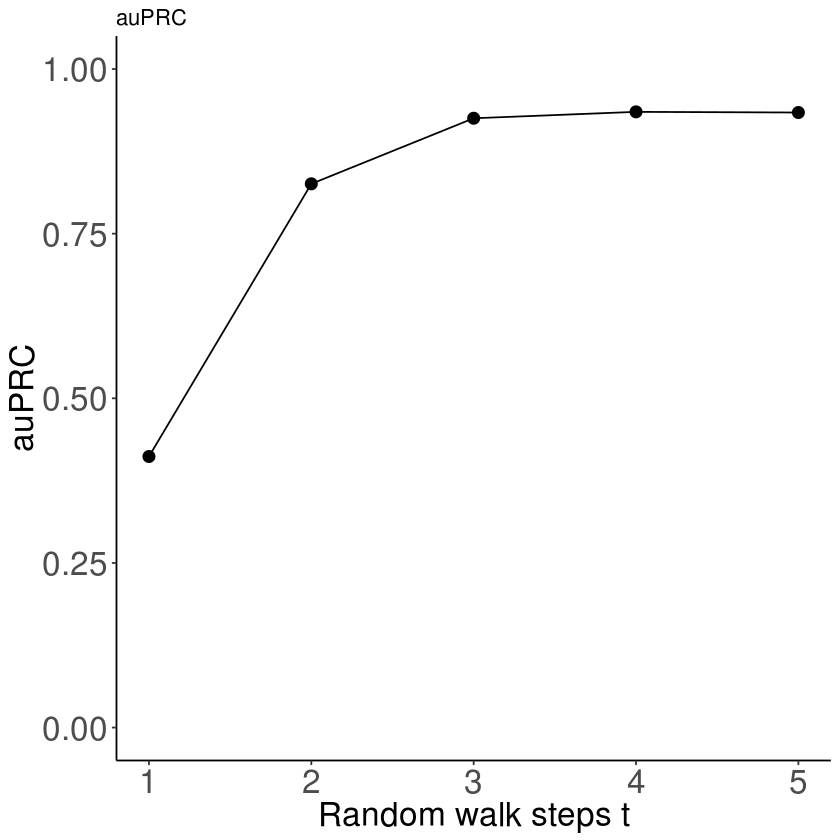

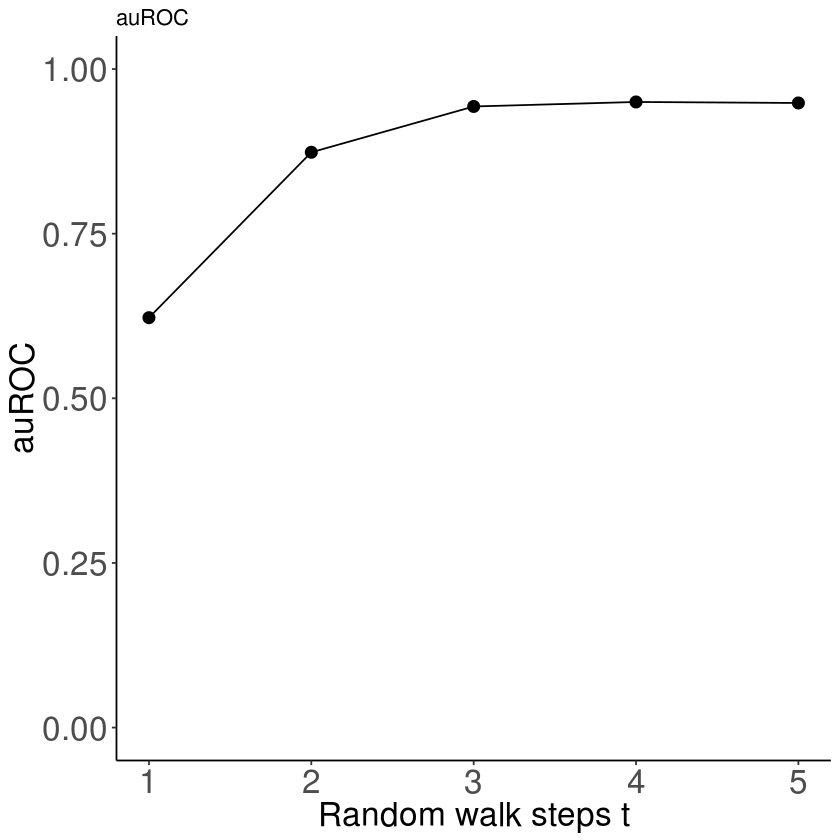

In [5]:
get_roc_pr_from_scores=function(scores){
    myroc=roc.curve(scores.class0=scores[,'score'], weights.class0=scores[,'biorep'],curve=TRUE)
    mypr=pr.curve(scores.class0=scores[,'score'], weights.class0=scores[,'biorep'],curve=TRUE)
    toreturn=list()
    toreturn[['roc']]=myroc[['auc']]
    toreturn[['pr']]=mypr[['auc.integral']]
    return(toreturn)
}

add_metadata=function(metadata,scores){
    scores=data.frame(scores,
                      seqdepth=apply(data.frame(metadata[as.character(scores[,'m1']),'totalReads'],metadata[as.character(scores[,'m2']),'totalReads']),1,min), 
                      cell1=metadata[as.character(scores[,'m1']),'celltype'],
                      cell2=metadata[as.character(scores[,'m2']),'celltype'],
                      re1=metadata[as.character(scores[,'m1']),'re'],
                      re2=metadata[as.character(scores[,'m2']),'re'],
                      crosslinking=paste(metadata[as.character(scores[,'m1']),'crosslinking'],metadata[as.character(scores[,'m2']),'crosslinking']),
                      protocol1=metadata[as.character(scores[,'m1']),'protocol'],
                      protocol2=metadata[as.character(scores[,'m2']),'protocol'])
    return(scores)
}

annotate_biorep_re=function(scores){
    scores=data.frame(scores,biorep=0,re=0)
    scores[which(scores[,'cell1']==scores[,'cell2']),'biorep']=1
    scores[which(scores[,'re1']==scores[,'re2']),'same_re']=1
    return(scores)
}

filter_insitu_crosslinked=function(scores){
    #restrict to in situ experiments
    in_situ=intersect(which(as.character(scores[,'protocol1'])=='in situ'),
                     which(as.character(scores[,'protocol2'])=='in situ'))
    
    #remove comparisons against un-crosslinked samples
    non_crosslink=which(grepl("NA",as.character(scores[,'crosslinking'])))

    #filter to keep only in-situ samples that have been crosslinked
    keep=setdiff(in_situ,non_crosslink)
    scores=scores[keep,]
    
    return(scores)
}

filter_data=function(scores,metadata){
    keep=intersect(which(as.character(scores[,'m1']) %in% rownames(metadata)),
                   which(as.character(scores[,'m2']) %in% rownames(metadata)))
    scores=scores[keep,]

    #fill in the entries from the metadata for the pairs
    scores=add_metadata(metadata,scores)
    
    #specify which are bioreps and which experiments are done with the same restriction enzyme
    scores=annotate_biorep_re(scores)
    
    #filter out comparisons that are not in situ or against non-crosslinked samples
    scores=filter_insitu_crosslinked(scores)
    return(scores)
}

auPRC_auROC_curve=function(scores_orig,metadata,out){
    FIG_WIDTH=4
    FIG_HEIGHT=3
    t_values=as.numeric(as.character(colnames(scores_orig)[3:(dim(scores_orig)[2])]))
    
    scores=filter_data(scores_orig,metadata)
    colnames(scores)[1:dim(scores_orig)[2]]=colnames(scores_orig)

    #Performance analysis with auROC and auPRC ================================
    auprc_values=c()
    auroc_values=c()
    for (t in t_values){
        current_scores=scores[,as.character(t)]
        roc_pr=get_roc_pr_from_scores(data.frame(biorep=scores[,'biorep'],score=current_scores))
        auprc_values=c(auprc_values,roc_pr[['pr']])
        auroc_values=c(auroc_values,roc_pr[['roc']])
    }
        
    #plot auPRC
    pdf(out,width=FIG_WIDTH,height=FIG_HEIGHT)
    auprcs=data.frame(t=t_values,auPRC=auprc_values)
    p=ggplot(auprcs,aes(x=t,y=auPRC))+theme_bw()+
    geom_point(size=3)+ylim(0,1)+xlab('Random walk steps t')+ylab('auPRC')+
    niceggplot+geom_line()+ggtitle('auPRC')
    print(p)
    dev.off()
    
    print(auprcs)
    Sys.sleep(3)
    print(p)     
    
    #plot auROC   
    aurocs=data.frame(t=t_values,auROC=auroc_values)
    p=ggplot(aurocs,aes(x=t,y=auROC))+theme_bw()+
    geom_point(size=3)+ylim(0,1)+xlab('Random walk steps t')+ylab('auROC')+
    niceggplot+geom_line()+ggtitle('auROC')
      
    print(aurocs)
    Sys.sleep(3)
    print(p)
}

print('Training set performance =============================')
auPRC_auROC_curve(disco_by_t,train_data,
                 paste(PLOTS_PATH,'/GenomeDISCO.train.auPRC_curve.pdf',sep=''))

print('Test set performance =============================')
auPRC_auROC_curve(disco_by_t,test_data,
                 paste(PLOTS_PATH,'/GenomeDISCO.test.auPRC_curve.pdf',sep=''))

Based on the above analysis, we used a value of *t*=3 as optimal. We fix this value for the following analyses. 

We also use the following thresholds of concordance, which are the highest scores obtained by non-replicates in this analysis.

In [6]:
GENOMEDISCO_THRESHOLD=0.8
HICREP_THRESHOLD=0.82
HICSPECTOR_THRESHOLD=0.27

**Comparing scores from GenomeDISCO with those from other methods** (Figure 3A)

Read in data

In [7]:
read_in_scores=function(f){
    scores=read.table(f)
    colnames(scores)=c('chromosome','m1','m2','score')
    #remove comparisons comparing one dataset to itself
    same=which(as.character(scores[,2])==as.character(scores[,3]))
    if (length(same)>0){
        scores=scores[-same,]
    }
    rownames(scores)=paste(as.character(scores[,2]),as.character(scores[,3]))
    return(scores[,-1])
}

disco=read_in_scores(paste(SCORES_PATH,'/HiC.GenomeDISCO.scores.genomewide.txt.gz',sep=''))
hicrep=read_in_scores(paste(SCORES_PATH,'/HiC.HiCRep.scores.genomewide.txt.gz',sep=''))
hicspector=read_in_scores(paste(SCORES_PATH,'/HiC.HiC-Spector.scores.genomewide.txt.gz',sep=''))


common=intersect(rownames(disco),intersect(rownames(hicrep),rownames(hicspector)))
allscores=data.frame(m1=disco[common,'m1'],m2=disco[common,'m2'],
                 GenomeDISCO=disco[common,'score'],
                 HiCRep=hicrep[common,'score'],
                 HiCSpector=hicspector[common,'score'])
head(allscores)

m1,m2,GenomeDISCO,HiCRep,HiCSpector
HIC048,HIC066,0.6792174,0.6785652,0.1678696
HIC048,HIC064,0.6287391,0.6990870,0.1682609
HIC012,HIC026,0.8634783,0.6996087,0.2200000
HIC048,HIC062,0.5795217,0.6757391,0.1953913
HIC048,HIC060,0.5642609,0.7022174,0.1937826
HIC048,HIC068,0.5798696,0.6508696,0.1344348


[1] "================== Comparing GenomeDISCO score and HiCRep score ==================="
[1] "Total comparisons considered"
[1] 465
[1] "Total biological replicates"
[1] 149
[1] "Union of comparisons deemed concordant by any of the two methods (bioreps + non-reps)"
[1] 124
[1] "- restricted to biological replicates"
[1] 124
[1] "Intersection of comparisons deemed concordant by both methods (bioreps + non-reps)"
[1] 69
[1] "- restricted to biological replicates"
[1] 69
[1] "Intersection of comparisons deemed non-concordant by both methods (bioreps + non-reps)"
[1] 341
[1] "- restricted to biological replicates"
[1] 25
[1] "Cases where methods agree in their classification of comparisons"
[1] 410
[1] "- restricted to biological replicates"
[1] 94
[1] "Cases where methods disagree in their classification of comparisons"
[1] 55
[1] "- restricted to biological replicates"
[1] 55
[1] "Concordant by other method but not GenomeDISCO"
[1] 34
[1] "- restricted to biological replicates"
[1] 34
[

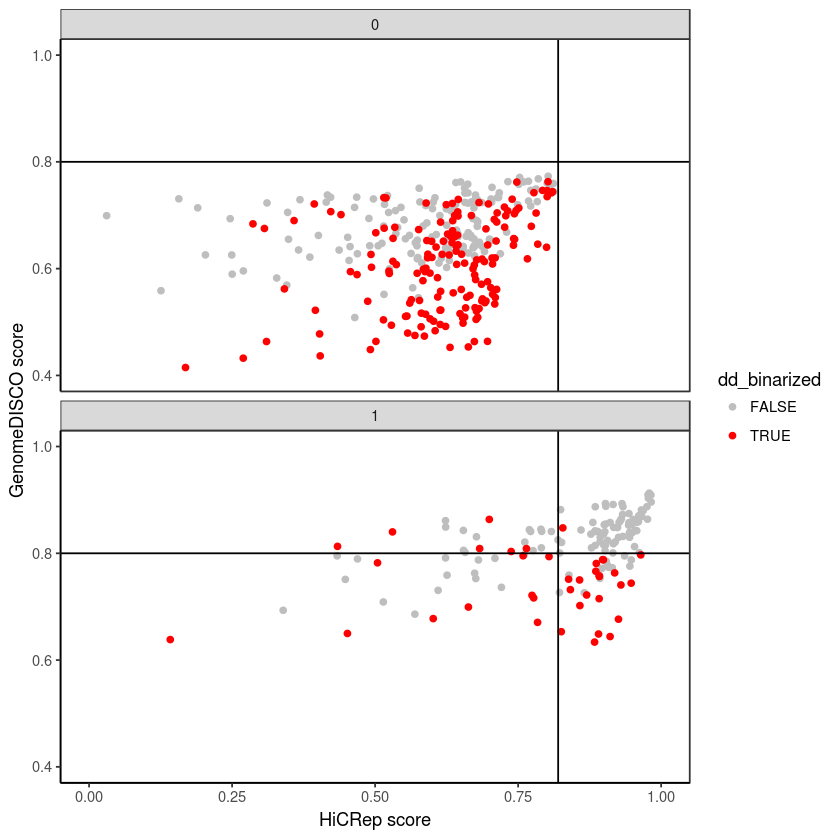

[1] "================== Comparing GenomeDISCO score and HiC-Spector score ==================="
[1] "Total comparisons considered"
[1] 465
[1] "Total biological replicates"
[1] 149
[1] "Union of comparisons deemed concordant by any of the two methods (bioreps + non-reps)"
[1] 113
[1] "- restricted to biological replicates"
[1] 113
[1] "Intersection of comparisons deemed concordant by both methods (bioreps + non-reps)"
[1] 66
[1] "- restricted to biological replicates"
[1] 66
[1] "Intersection of comparisons deemed non-concordant by both methods (bioreps + non-reps)"
[1] 352
[1] "- restricted to biological replicates"
[1] 36
[1] "Cases where methods agree in their classification of comparisons"
[1] 418
[1] "- restricted to biological replicates"
[1] 102
[1] "Cases where methods disagree in their classification of comparisons"
[1] 47
[1] "- restricted to biological replicates"
[1] 47
[1] "Concordant by other method but not GenomeDISCO"
[1] 23
[1] "- restricted to biological replicates"
[1

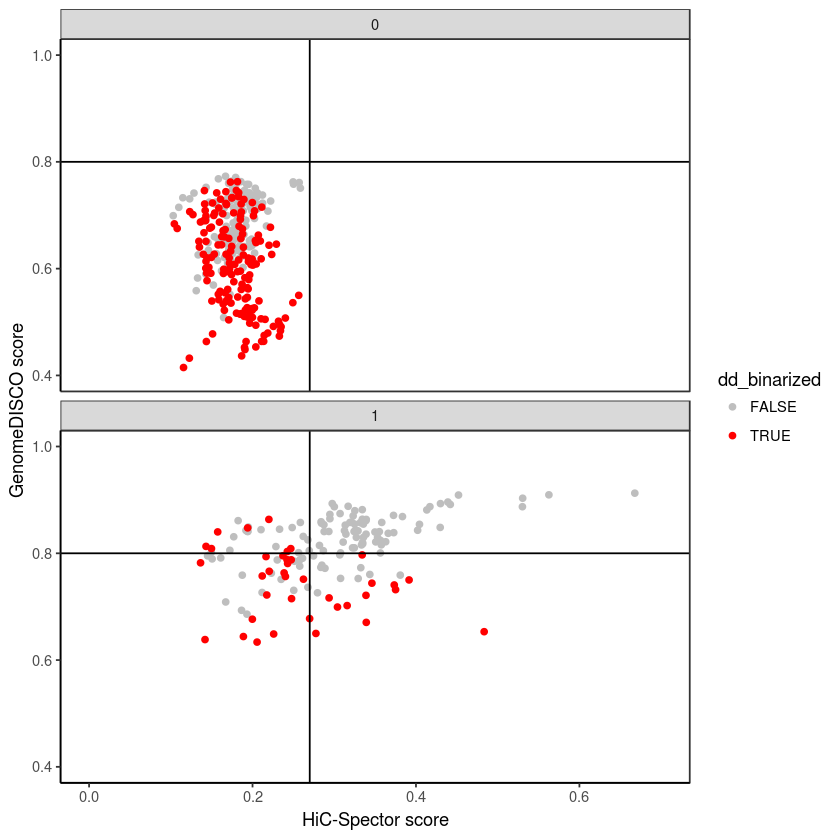

In [26]:
compare_methods=function(scores1,scores2,ddfile,s1name,s2name,metadata,thresh1,thresh2,out,xmin,xmax,ymin,ymax,dist_dep_thresh){
    #======= settings for nice-looking ggplots
    niceggplot=theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

    niceggplot_fullborders=theme(axis.text=element_text(size=20),
                             axis.title=element_text(size=20))
    #==========================================
    
    #set column and row names
    colnames(scores1)[3]='score'
    colnames(scores2)[3]='score'
    rownames(scores1)=paste(as.character(scores1[,'m1']),as.character(scores1[,'m2']))
    rownames(scores2)=paste(as.character(scores2[,'m1']),as.character(scores2[,'m2']))
    
    #filter data to only keep in situ samples and samples that have been crosslinked
    scores1=filter_data(scores1,metadata)
    scores2=filter_data(scores2,metadata)
    
    #read in differences in distance dependence
    dds=read.table(ddfile)
    rownames(dds)=paste(dds[,1],dds[,2])
    
    #combine scores in one data frame, annotated
    common=intersect(rownames(scores1),rownames(scores2))
    combined=data.frame(m1=scores1[common,'m1'],
                        m2=scores1[common,'m2'],
                        s1=scores1[common,'score'],
                        s2=scores2[common,'score'],
                        dd=dds[common,3],
                        biorep=scores1[common,'biorep'],
                        seqdepth=scores1[common,'seqdepth'])
    combined=combined[order(as.numeric(as.character(combined$dd))),]
    combined=data.frame(combined,dd_binarized=(as.numeric(as.character(combined[,'dd']))>=dist_dep_thresh))
    
    #scatterplot of scores coming from the 2 methods
    FIG_WIDTH=6
    FIG_HEIGHT=10
    MAX_DD_DIFF=0.025
    pdf(paste(out,'.dd.pdf',sep=''),width=FIG_WIDTH,height=FIG_HEIGHT)
    p=ggplot(combined,aes(x=s2,y=s1,col=dd_binarized))+
         geom_point(size=1.5)+xlab(s2name)+ylab(s1name)+
         theme_bw()+facet_wrap(~biorep,nrow=2)+
         scale_colour_manual(values = c('gray','red'))+
         geom_hline(yintercept = thresh2)+geom_vline(xintercept = thresh1)+
         xlim(xmin,xmax)+ylim(ymin,ymax)+niceggplot
    print(p)
    dev.off()
    print(p)  
    
    #======================================================
    #print numbers relevant for the cross-method comparison
    #======================================================
    print(paste('==================','Comparing',s1name,'and',s2name,'==================='))
    print('Total comparisons considered')
    print(dim(combined)[1])
    print('Total biological replicates')
    bioreps=which(as.character(combined$biorep)=='1')
    print(length(bioreps))
    #split into concordant and nonconcordant
    conc1=which(as.numeric(as.character(combined[,'s1']))>=thresh2)
    conc2=which(as.numeric(as.character(combined[,'s2']))>=thresh1)
    nonconc1=which(as.numeric(as.character(combined[,'s1']))<thresh2)
    nonconc2=which(as.numeric(as.character(combined[,'s2']))<thresh1)

    print('Union of comparisons deemed concordant by any of the two methods (bioreps + non-reps)')
    print(length(union(conc1,conc2)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,union(conc1,conc2))))
    
    print('Intersection of comparisons deemed concordant by both methods (bioreps + non-reps)')
    print(length(intersect(conc1,conc2)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,intersect(conc1,conc2))))
    
    print('Intersection of comparisons deemed non-concordant by both methods (bioreps + non-reps)')
    print(length(intersect(nonconc1,nonconc2)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,intersect(nonconc1,nonconc2))))
    
    print('Cases where methods agree in their classification of comparisons')
    print(length(intersect(conc1,conc2))+length(intersect(nonconc1,nonconc2)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,intersect(conc1,conc2)))+
          length(intersect(bioreps,intersect(nonconc1,nonconc2))))
    
    print('Cases where methods disagree in their classification of comparisons')
    print(dim(combined)[1]-(length(intersect(conc1,conc2))+length(intersect(nonconc1,nonconc2))))
    print('- restricted to biological replicates')
    print(length(bioreps)-(length(intersect(bioreps,intersect(conc1,conc2)))+
          length(intersect(bioreps,intersect(nonconc1,nonconc2)))))
    
    print('Concordant by other method but not GenomeDISCO')
    print(length(setdiff(conc2,conc1)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,setdiff(conc2,conc1))))
    
    print('Concordant by other method but not GenomeDISCO, explained by distance dep')
    dist_dep_diff=which(as.numeric(as.character(combined$dd))>=dist_dep_thresh)
    print(length(intersect(dist_dep_diff,setdiff(conc2,conc1))))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,intersect(dist_dep_diff,setdiff(conc2,conc1)))))
    
    print('Concordant by GenomeDISCO, not the other method')
    print(length(setdiff(conc1,conc2)))
    print('- restricted to biological replicates')
    print(length(intersect(bioreps,setdiff(conc1,conc2))))
    
}

HICREP_MIN=0
HICREP_MAX=1
GENOMEDISCO_MIN=0.4
GENOMEDISCO_MAX=1
HICSPECTOR_MIN=0
HICSPECTOR_MAX=0.7
DIST_DEP_THRESHOLD=0.005

compare_methods(allscores[,c('m1','m2','GenomeDISCO')],allscores[,c('m1','m2','HiCRep')],
               DISTDEP_FILE,
                'GenomeDISCO score','HiCRep score',
                test_data,
                HICREP_THRESHOLD,GENOMEDISCO_THRESHOLD,
                paste(PLOTS_PATH,'/GenomeDISCO.vs.HiCRep.pdf',sep=''),
                HICREP_MIN,HICREP_MAX,GENOMEDISCO_MIN,GENOMEDISCO_MAX,DIST_DEP_THRESHOLD)

compare_methods(allscores[,c('m1','m2','GenomeDISCO')],allscores[,c('m1','m2','HiCSpector')],
               DISTDEP_FILE,
                'GenomeDISCO score','HiC-Spector score',
                test_data,
                HICSPECTOR_THRESHOLD,GENOMEDISCO_THRESHOLD,
                paste(PLOTS_PATH,'/GenomeDISCO.vs.HiCSpector.pdf',sep=''),
                HICSPECTOR_MIN,HICSPECTOR_MAX,GENOMEDISCO_MIN,GENOMEDISCO_MAX,DIST_DEP_THRESHOLD)


Computing concordance across all 3 methods

In [89]:
#keep our set of in-situ, crosslinked bioreps
combo=filter_data(allscores,test_data)
bioreps=which(as.character(combo[,'biorep'])=='1')
dds=read.table(DISTDEP_FILE)
rownames(dds)=paste(dds[,1],dds[,2])
combo=combo[bioreps,]
rownames(combo)=paste(as.character(combo[,'m1']),as.character(combo[,'m2']))
combo=data.frame(combo,dd=dds[rownames(combo),3])

print('Concordant only by GenomeDISCO (bioreps only)')
disco_only=intersect(intersect(which(as.numeric(as.character(combo[,'GenomeDISCO']))>=GENOMEDISCO_THRESHOLD),
                           which(as.numeric(as.character(combo[,'HiCRep']))<HICREP_THRESHOLD)),
                 which(as.numeric(as.character(combo[,'HiCSpector']))<HICSPECTOR_THRESHOLD))
print(length(disco_only))
print(combo[disco_only,])

print('Concordant only by HiCRep (bioreps only)')
hicrep_only=intersect(intersect(which(as.numeric(as.character(combo[,'GenomeDISCO']))<GENOMEDISCO_THRESHOLD),
                           which(as.numeric(as.character(combo[,'HiCRep']))>=HICREP_THRESHOLD)),
                 which(as.numeric(as.character(combo[,'HiCSpector']))<HICSPECTOR_THRESHOLD))
print(length(hicrep_only))
print(combo[hicrep_only,])

print('Concordant only by HiC-Spector (bioreps only)')
hicspector_only=intersect(intersect(which(as.numeric(as.character(combo[,'GenomeDISCO']))<GENOMEDISCO_THRESHOLD),
                           which(as.numeric(as.character(combo[,'HiCRep']))<HICREP_THRESHOLD)),
                 which(as.numeric(as.character(combo[,'HiCSpector']))>=HICSPECTOR_THRESHOLD))
print(length(hicspector_only))
print(combo[hicspector_only,])

print('Non-concordant by all methods (bioreps only)')
non=intersect(intersect(which(as.numeric(as.character(combo[,'GenomeDISCO']))<GENOMEDISCO_THRESHOLD),
                           which(as.numeric(as.character(combo[,'HiCRep']))<HICREP_THRESHOLD)),
                 which(as.numeric(as.character(combo[,'HiCSpector']))<HICSPECTOR_THRESHOLD))
print(length(non))
print(combo[non,])

[1] "Concordant only by GenomeDISCO (bioreps only)"
[1] 18
                  m1     m2 GenomeDISCO    HiCRep HiCSpector  seqdepth   cell1
HIC012 HIC026 HIC012 HIC026   0.8634783 0.6996087  0.2200000 194217179 GM12878
HIC004 HIC040 HIC004 HIC040   0.8033478 0.7378696  0.2425652 125709561 GM12878
HIC006 HIC012 HIC006 HIC012   0.8428261 0.6542609  0.1919565 153771943 GM12878
HIC008 HIC012 HIC008 HIC012   0.8611304 0.6230435  0.1823913 194217179 GM12878
HIC008 HIC014 HIC008 HIC014   0.8129130 0.4343043  0.1430870 212099519 GM12878
HIC010 HIC016 HIC010 HIC016   0.8250870 0.8196957  0.2677391  55813939 GM12878
HIC004 HIC012 HIC004 HIC012   0.8491304 0.6233913  0.1948261 160649365 GM12878
HIC014 HIC026 HIC014 HIC026   0.8400435 0.5303913  0.1573913 309986657 GM12878
HIC014 HIC024 HIC014 HIC024   0.8088261 0.6827826  0.1497391 111656957 GM12878
HIC012 HIC028 HIC012 HIC028   0.8409565 0.7911739  0.1943478  74167365 GM12878
HIC012 HIC020 HIC012 HIC020   0.8450870 0.7898696  0.2330870 194217179 G

[1] "Concordant only by HiC-Spector (bioreps only)"
[1] 7
                  m1     m2 GenomeDISCO    HiCRep HiCSpector  seqdepth   cell1
HIC016 HIC048 HIC016 HIC048   0.6498261 0.4516087  0.2775652  97520628 GM12878
HIC016 HIC042 HIC016 HIC042   0.7212174 0.7743478  0.3388261 136425264 GM12878
HIC018 HIC048 HIC018 HIC048   0.7526957 0.6760000  0.3293043  97520628 GM12878
HIC028 HIC048 HIC028 HIC048   0.6993043 0.6630870  0.3039565  74167365 GM12878
HIC010 HIC048 HIC010 HIC048   0.7164348 0.7771739  0.2936957  55813939 GM12878
HIC042 HIC048 HIC042 HIC048   0.7970000 0.7605217  0.3067826  97520628 GM12878
HIC026 HIC048 HIC026 HIC048   0.6705652 0.7840000  0.3391739  97520628 GM12878
                cell2   re1   re2                  crosslinking protocol1
HIC016 HIC048 GM12878  MboI  MboI 1% FA 10min RT 1% FA 10min RT   in situ
HIC016 HIC042 GM12878  MboI DpnII 1% FA 10min RT 1% FA 10min RT   in situ
HIC018 HIC048 GM12878  MboI  MboI 1% FA 10min RT 1% FA 10min RT   in situ
HIC028 HIC048 

Also, print all biological replicates, this time sorted by their difference in distance dependence curves

In [92]:
print(combo[order(as.numeric(as.character(combo[,'dd'])),decreasing=TRUE),])

                  m1     m2 GenomeDISCO    HiCRep HiCSpector  seqdepth
HIC070 HIC072 HIC070 HIC072   0.6440435 0.9107826  0.1888261  79578049
HIC026 HIC040 HIC026 HIC040   0.7514348 0.8382609  0.2623043 125709561
HIC070 HIC074 HIC070 HIC074   0.6765217 0.9254348  0.1997826  80778733
HIC026 HIC038 HIC026 HIC038   0.7150000 0.8916522  0.2477391 101689129
HIC026 HIC048 HIC026 HIC048   0.6705652 0.7840000  0.3391739  97520628
HIC016 HIC038 HIC016 HIC038   0.7020435 0.8580000  0.3157826 101689129
HIC016 HIC048 HIC016 HIC048   0.6498261 0.4516087  0.2775652  97520628
HIC016 HIC040 HIC016 HIC040   0.7406522 0.9296957  0.3734348 125709561
HIC014 HIC026 HIC014 HIC026   0.8400435 0.5303913  0.1573913 309986657
HIC024 HIC040 HIC024 HIC040   0.7632609 0.9187826  0.2386522 111656957
HIC028 HIC048 HIC028 HIC048   0.6993043 0.6630870  0.3039565  74167365
HIC024 HIC038 HIC024 HIC038   0.7218696 0.8698261  0.2174783 101689129
HIC028 HIC038 HIC028 HIC038   0.7565217 0.8920000  0.2402609  74167365
HIC028

Plot scores vs difference in distance dependence

Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

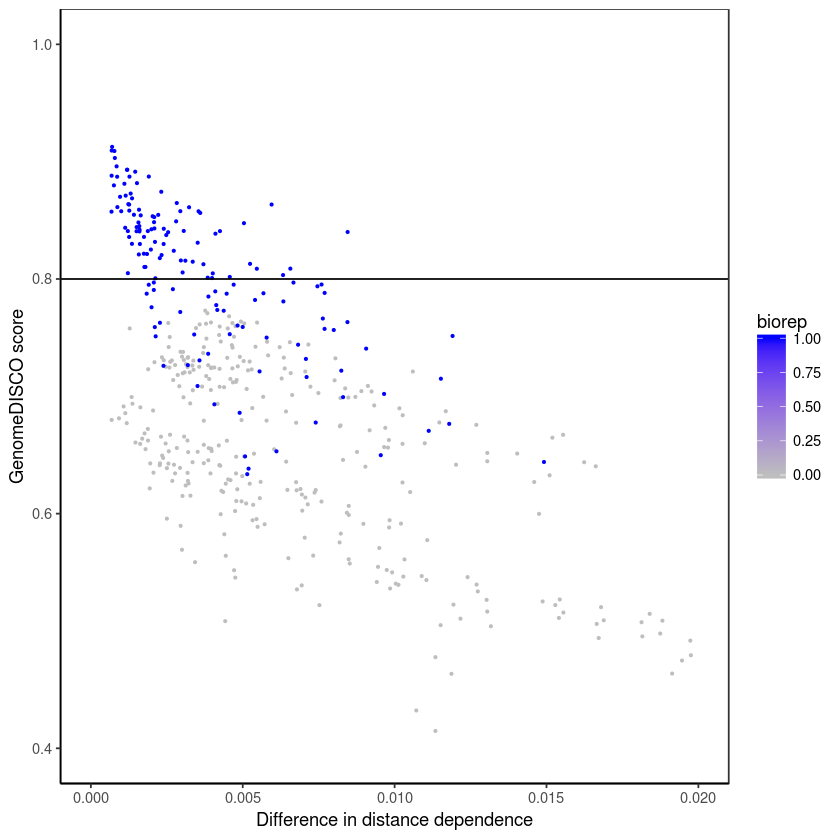

Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

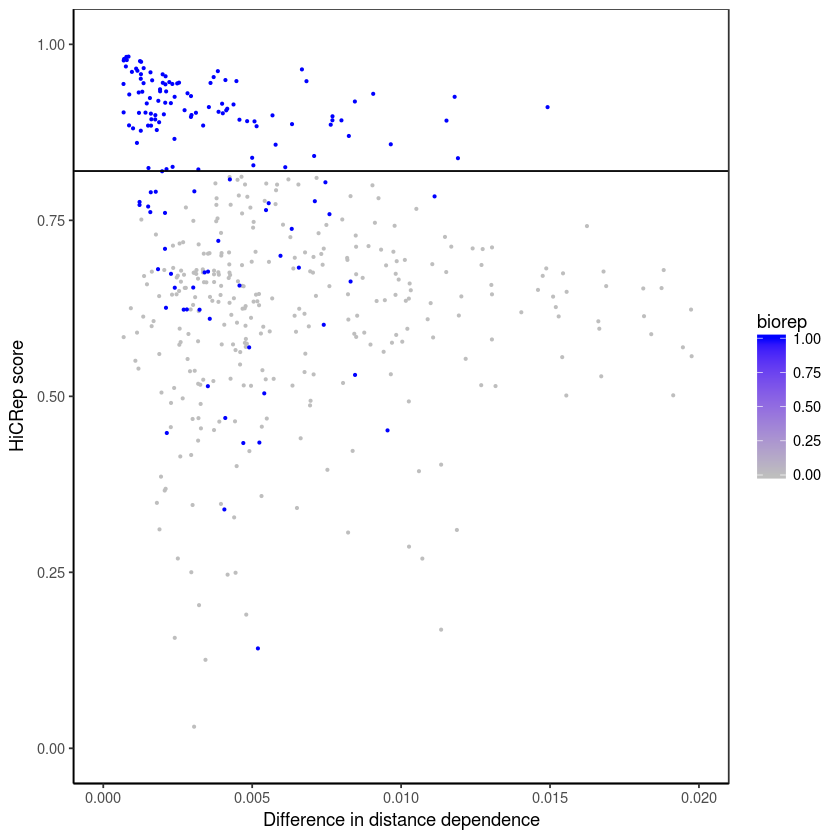

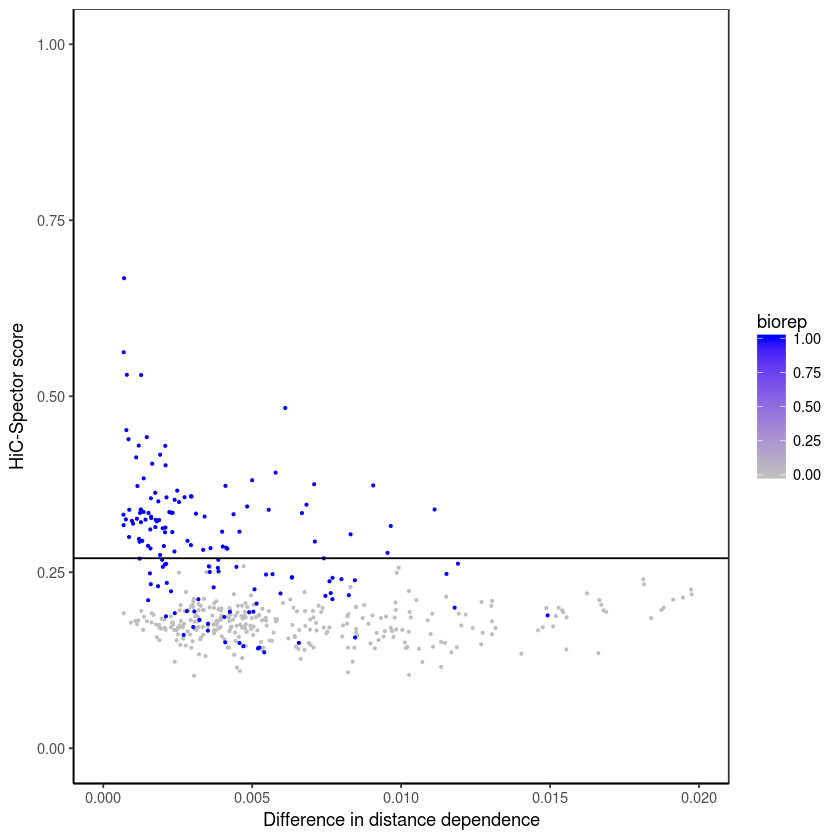

In [100]:
plot_single_score_vs_covariates=function(scores,ddfile,sname,metadata,thresh,out,mini){
    #======= settings for nice-looking ggplots
    niceggplot=theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

    niceggplot_fullborders=theme(axis.text=element_text(size=20),
                             axis.title=element_text(size=20))
    #==========================================
    
    colnames(scores)[3]='score'
    scores=filter_data(scores,metadata)
    rownames(scores)=paste(as.character(scores[,'m1']),as.character(scores[,'m2']))
    
    dds=read.table(ddfile)
    rownames(dds)=paste(dds[,1],dds[,2])
    
    common=rownames(scores)
    
    combined=data.frame(score=scores[common,'score'],
                        dd=dds[common,3],
                        biorep=scores[common,'biorep'],
                        seqdepth=scores[common,'seqdepth'])
    
    combined=combined[order(as.numeric(as.character(combined$biorep)),decreasing=FALSE),]
    pdf(paste(out,'.vs.dd.pdf',sep=''),width=4,height=3)
    p=ggplot(combined,aes(x=dd,y=score,color=biorep))+geom_point(size=0.5)+xlab('Difference in distance dependence')+
         ylab(sname)+
         theme_bw()+scale_colour_gradient(low = "gray", high = "blue")+
         geom_hline(yintercept = thresh)+ylim(mini,1)+xlim(0,0.02)+niceggplot
    print(p)
    dev.off()
    print(p)   
}

plot_single_score_vs_covariates(allscores[,c('m1','m2','GenomeDISCO')],
               DISTDEP_FILE,
                'GenomeDISCO score',
                test_data,GENOMEDISCO_THRESHOLD,
               paste(PLOTS_PATH,'/GenomeDISCO',sep=''),GENOMEDISCO_MIN)

plot_single_score_vs_covariates(allscores[,c('m1','m2','HiCRep')],
               DISTDEP_FILE,
                'HiCRep score',
                test_data,HICREP_THRESHOLD,
               paste(PLOTS_PATH,'/HiCRep',sep=''),HICREP_MIN)

plot_single_score_vs_covariates(allscores[,c('m1','m2','HiCSpector')],
               DISTDEP_FILE,
                'HiC-Spector score',
                test_data,HICSPECTOR_THRESHOLD,
               paste(PLOTS_PATH,'/HiC-Spector',sep=''),0)


Supplementary Figure about clustering of Rao samples
===

In [110]:
require(mclust,lib.loc='~/R/x86_64-pc-linux-gnu-library/3.4')
require(cba,lib.loc='~/R/x86_64-pc-linux-gnu-library/3.4')
require(ggdendro,lib.loc='~/R/x86_64-pc-linux-gnu-library/3.4')

Loading required package: cba


$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
TableGrob (5 x 6) "layout": 6 grobs
  z     cells      name                          grob
1 1 (2-2,3-3)  col_tree polyline[GRID.polyline.11345]
2 2 (4-4,1-1)  row_tree polyline[GRID.polyline.11346]
3 3 (4-4,3-3)    matrix       gTree[GRID.gTree.11349]
4 4 (5-5,3-3) col_names         text[GRID.text.11350]
5 5 (4-4,4-4) row_names         text[GRID.text.11351]
6 6 (3-5,5-5)    legend       gTree[GRID.gTree.11354]

$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
Table

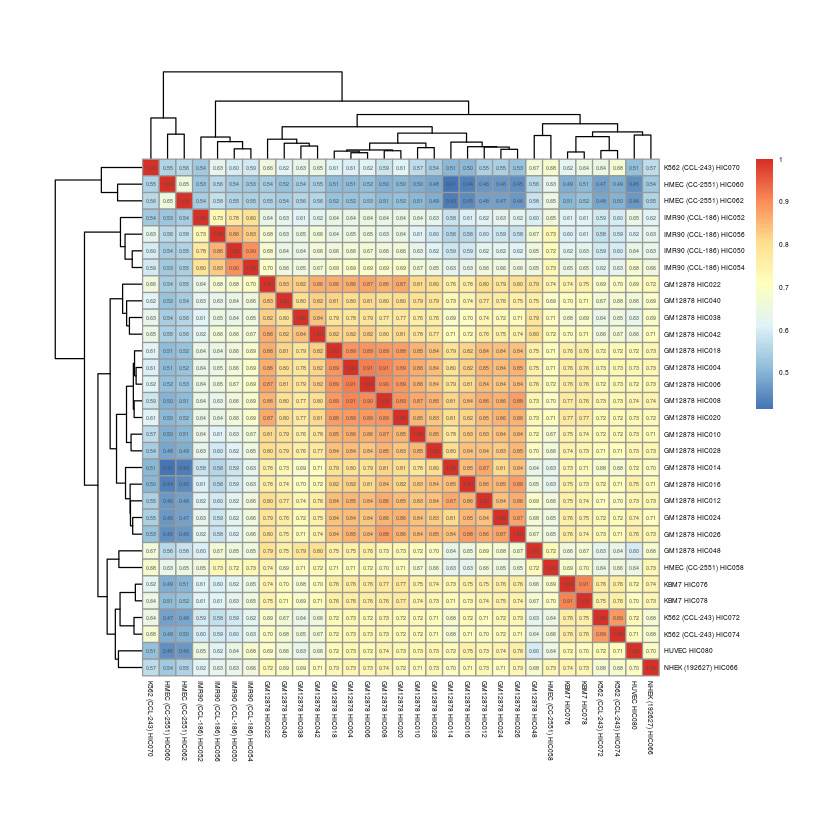

$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
TableGrob (5 x 6) "layout": 6 grobs
  z     cells      name                          grob
1 1 (2-2,3-3)  col_tree polyline[GRID.polyline.11441]
2 2 (4-4,1-1)  row_tree polyline[GRID.polyline.11442]
3 3 (4-4,3-3)    matrix       gTree[GRID.gTree.11445]
4 4 (5-5,3-3) col_names         text[GRID.text.11446]
5 5 (4-4,4-4) row_names         text[GRID.text.11447]
6 6 (3-5,5-5)    legend       gTree[GRID.gTree.11450]

$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
Table

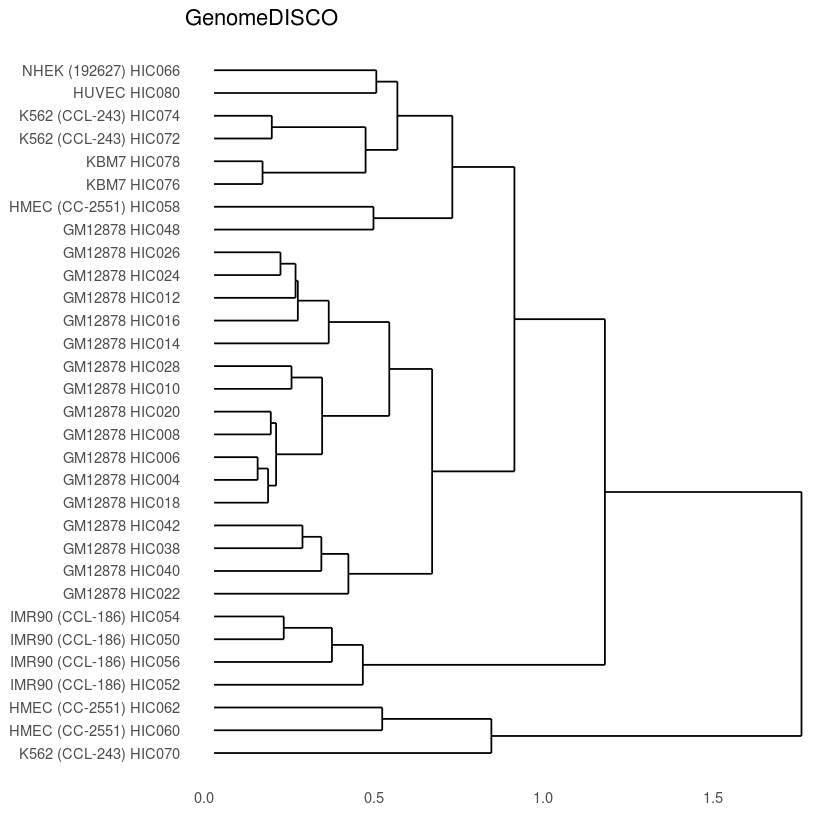

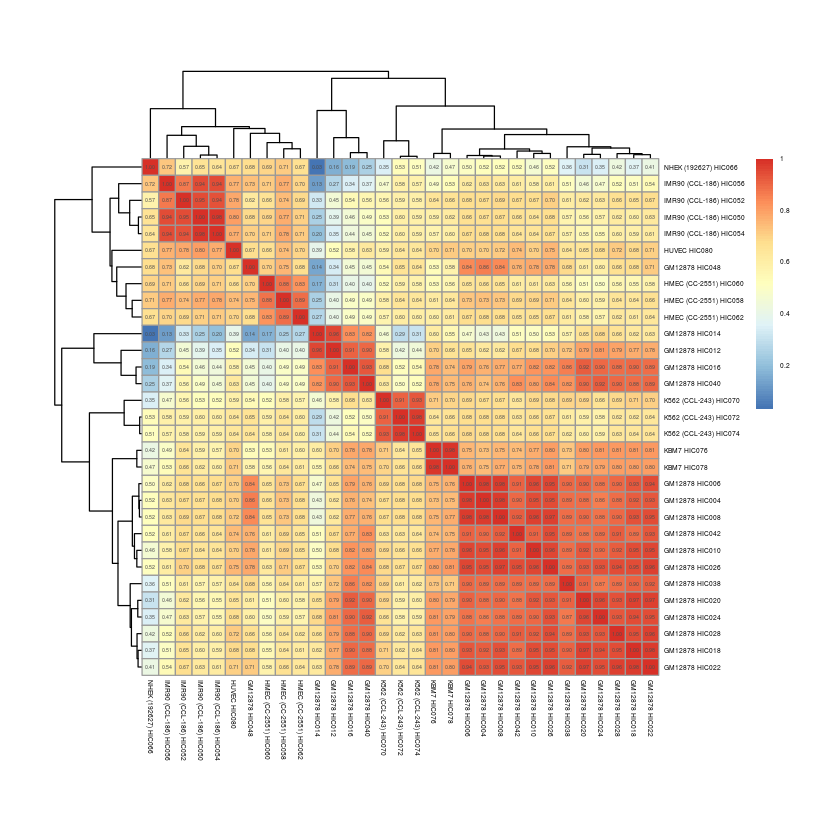

$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
TableGrob (5 x 6) "layout": 6 grobs
  z     cells      name                          grob
1 1 (2-2,3-3)  col_tree polyline[GRID.polyline.11537]
2 2 (4-4,1-1)  row_tree polyline[GRID.polyline.11538]
3 3 (4-4,3-3)    matrix       gTree[GRID.gTree.11541]
4 4 (5-5,3-3) col_names         text[GRID.text.11542]
5 5 (4-4,4-4) row_names         text[GRID.text.11543]
6 6 (3-5,5-5)    legend       gTree[GRID.gTree.11546]

$tree_row

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$tree_col

Call:
hclust(d = d, method = method)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 31 


$kmeans
[1] NA

$gtable
Table

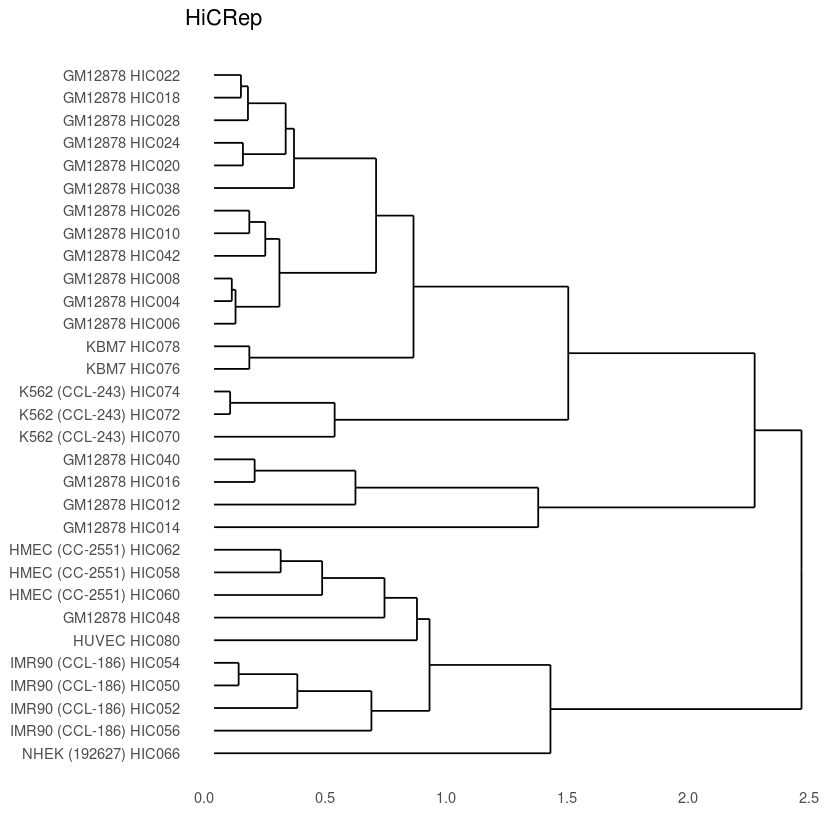

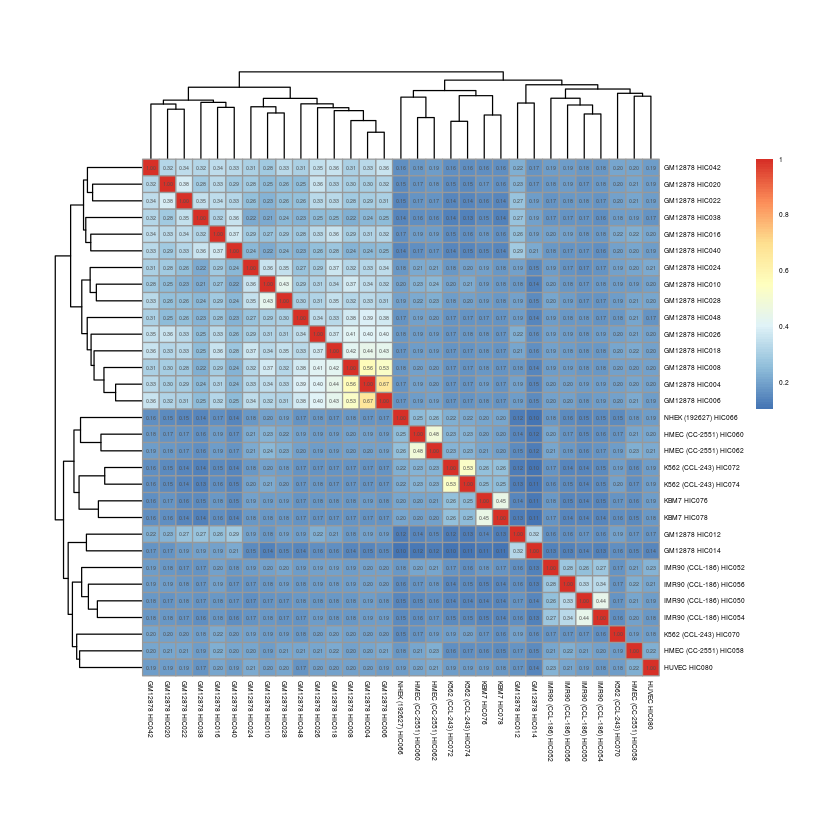

png 
  2

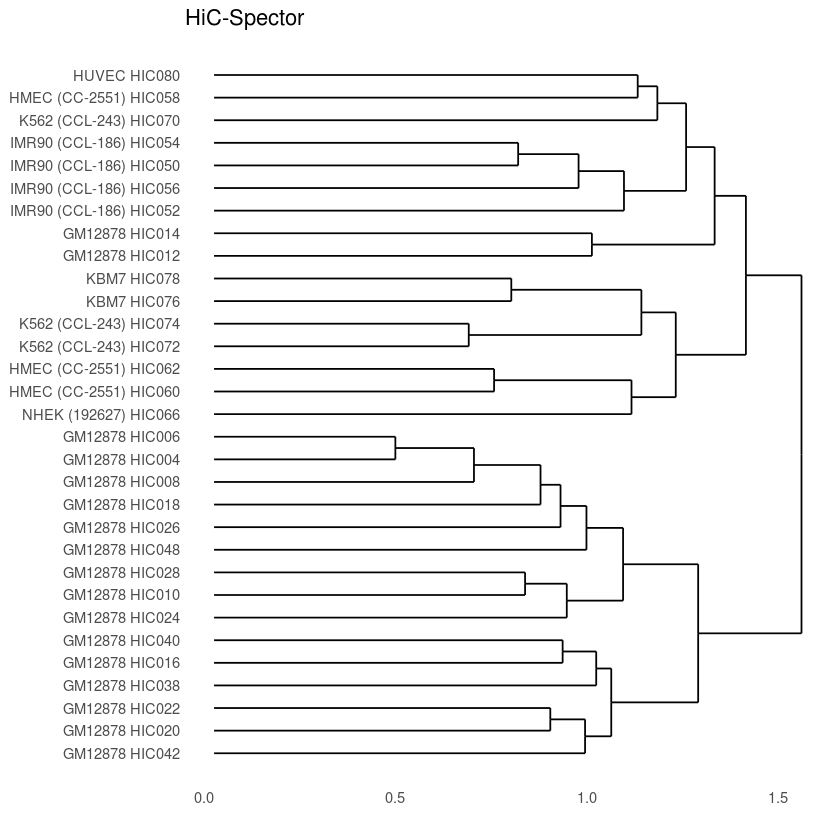

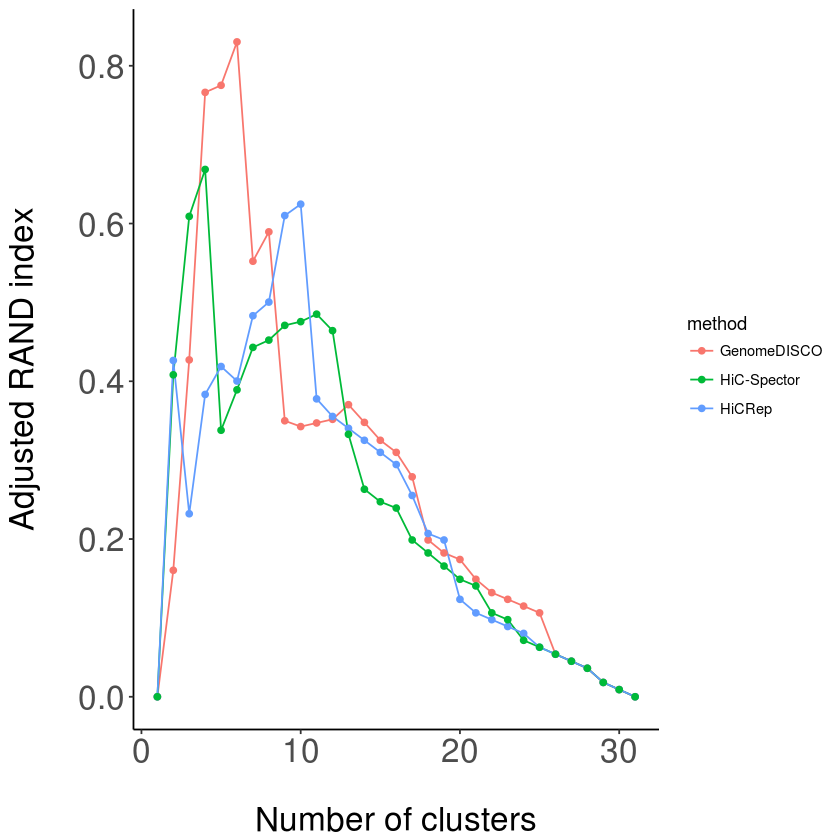

In [109]:
optimal_ordering=function(m,meth){
  if (dim(m)[1]<=2){
  return (m)
  }
  require(cba)
  d=dist(as.matrix(m),method=meth)
  hc=hclust(d)
  co=order.optimal(d, hc$merge)
  m.optimalRows=as.matrix(m)[co$order,]
  return(m.optimalRows)
}

get_score_heatmap=function(scores_orig,metadata,title,out){
    colnames(scores_orig)[3]='score'
    SCORECOL=3
    scores=filter_data(scores_orig,metadata)
    rownames(scores)=paste(as.character(scores[,'m1']),as.character(scores[,'m2']))
    
    #mapping from sample to cell type
    sample2cell=data.frame(sample=c(as.character(scores[,'m1']),as.character(scores[,'m2'])),
                                    cell=c(as.character(scores[,'cell1']),as.character(scores[,'cell2'])))
    dups=which(duplicated(sample2cell))
    if (length(dups)>0){
        sample2cell=sample2cell[-dups,]
    }
    rownames(sample2cell)=paste(as.character(sample2cell[,'cell']),as.character(sample2cell[,'sample']))
    
    #put the scores in a nice heatmap
    scores_short=scores
    scores_short[,1]=paste(as.character(scores_short[,'cell1']),as.character(scores_short[,'m1']))
    scores_short[,2]=paste(as.character(scores_short[,'cell2']),as.character(scores_short[,'m2']))
    samples=unique(c(scores_short[,1],scores_short[,2]))
    samples=samples[order(samples)]
    m=as.matrix(array(1,dim=c(length(samples),length(samples))))
    rownames(m)=colnames(m)=samples
    for (i in c(1:(dim(scores_short)[1]))){
        n1=as.character(scores_short[i,1])
        n2=as.character(scores_short[i,2])
        v=scores_short[i,SCORECOL]
        m[n1,n2]=v
        m[n2,n1]=v
    } 
    
    #plot heatmap
    pdf(paste(out,'.',title,'.heatmap.pdf',sep=''))
    print(pheatmap(m,display_numbers = TRUE, number_format = "%.2f",
            cellwidth=10,cellheight=10,fontsize=4))
    dev.off()
    print(pheatmap(m,display_numbers = TRUE, number_format = "%.2f",
            cellwidth=10,cellheight=10,fontsize=4))
    
    #plot dendrogram
    hc = hclust(dist(m))
    pdf(paste(out,'.',title,'.dendrogram.pdf',sep=''))
    p=ggdendrogram(hc, rotate = TRUE, size = 4)+ggtitle(title)
    print(p)
    dev.off()
    print(p)
    
    #compute arand scores
    ks=c(1:length(samples))
    arands=c()
    #mis=c()
    for (k in ks){
        thecut=cutree(hc,k=k)
        arands=c(arands,adjustedRandIndex(thecut[rownames(sample2cell)],sample2cell[,'cell']))
     } 
    return(arands)
}

gdisco_arand=get_score_heatmap(allscores[,c('m1','m2','GenomeDISCO')],test_data,'GenomeDISCO',
                               paste(PLOTS_PATH,'/analysis',sep=''))

hicrep_arand=get_score_heatmap(allscores[,c('m1','m2','HiCRep')],test_data,'HiCRep',
                               paste(PLOTS_PATH,'/analysis',sep=''))

spector_arand=get_score_heatmap(allscores[,c('m1','m2','HiCSpector')],test_data,'HiC-Spector',
                               paste(PLOTS_PATH,'/analysis',sep=''))


arands=data.frame(k=rep(c(1:length(gdisco_arand)),times=3),
                  ARAND=c(gdisco_arand,hicrep_arand,spector_arand),
                  method=c(rep('GenomeDISCO',times=length(gdisco_arand)),
                           rep('HiCRep',times=length(gdisco_arand)),
                           rep('HiC-Spector',times=length(gdisco_arand))))

pdf(paste(PLOTS_PATH,'/arand.pdf',sep=''),width=7,height=5)
p=ggplot(arands,aes(x=k,y=ARAND,col=method))+geom_line()+geom_point()+theme_bw()+niceggplot+
     xlab('\nNumber of clusters')+ylab('Adjusted RAND index\n')
print(p)
dev.off()
print(p)


Supplementary Figure about differences in protocols etc.
===


- different experiment protocols (dilute Hi-C vs. in-situ Hi-C)
- different restriction enzymes (HindIII vs. NcoI vs. MboI)

**different experiment protocols**

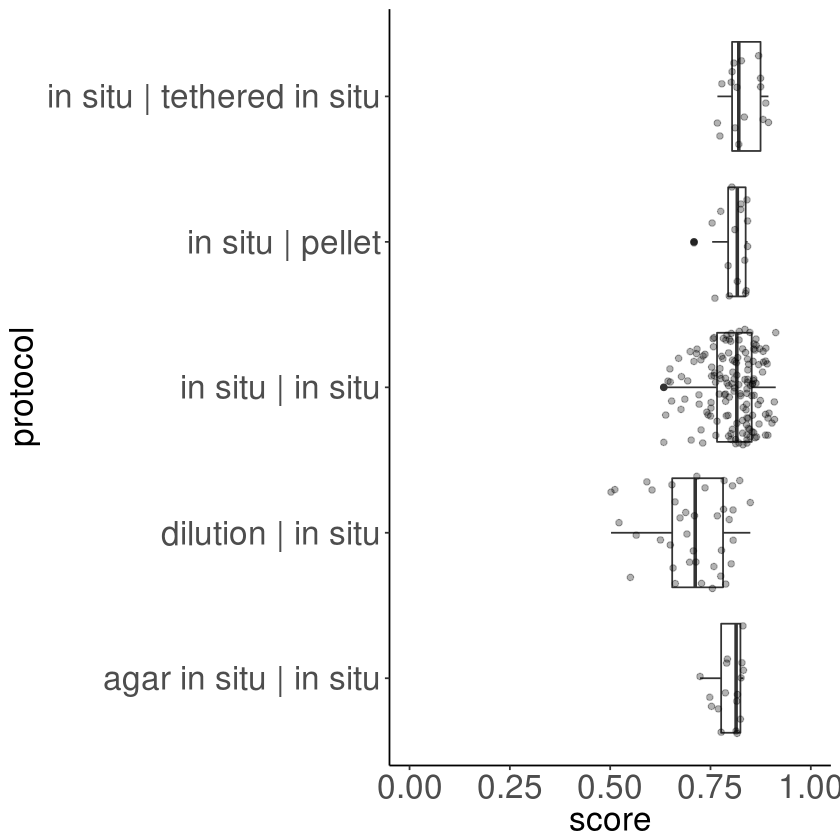

png 
  2

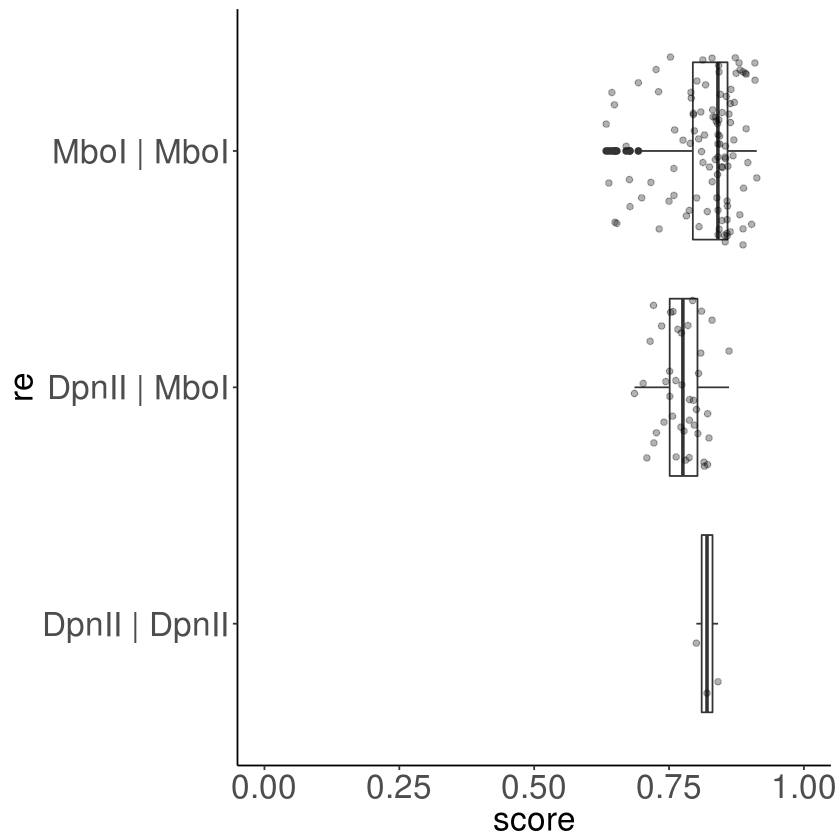

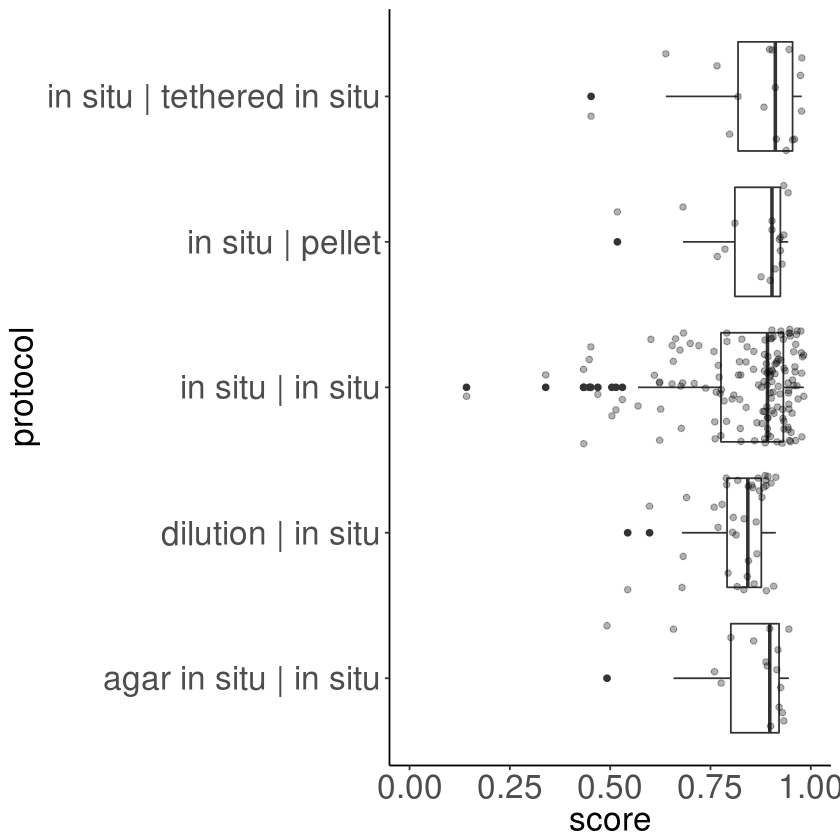

png 
  2

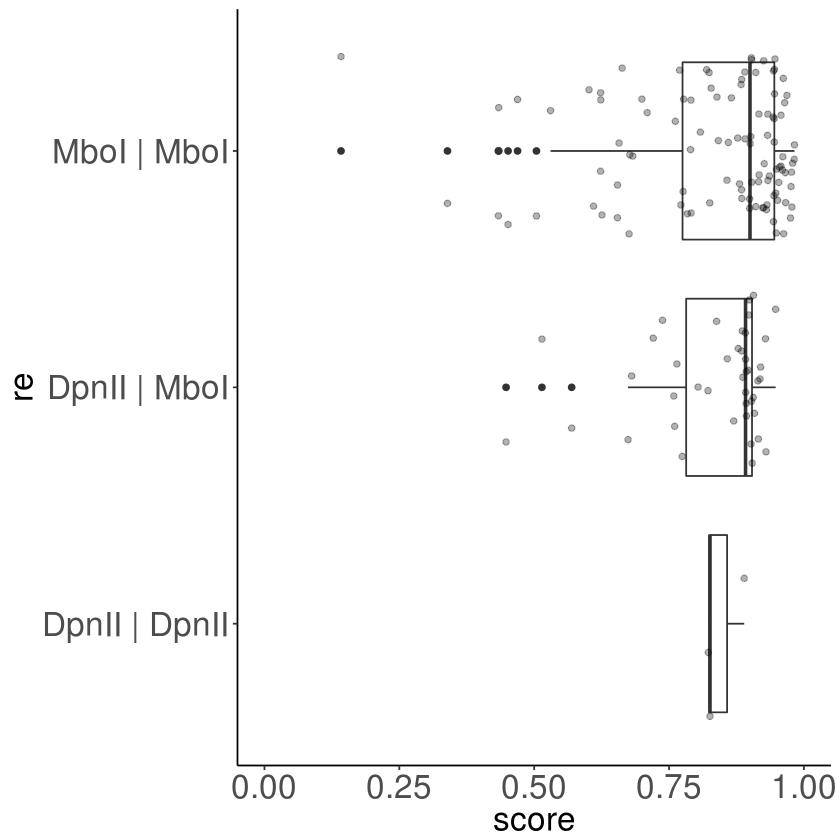

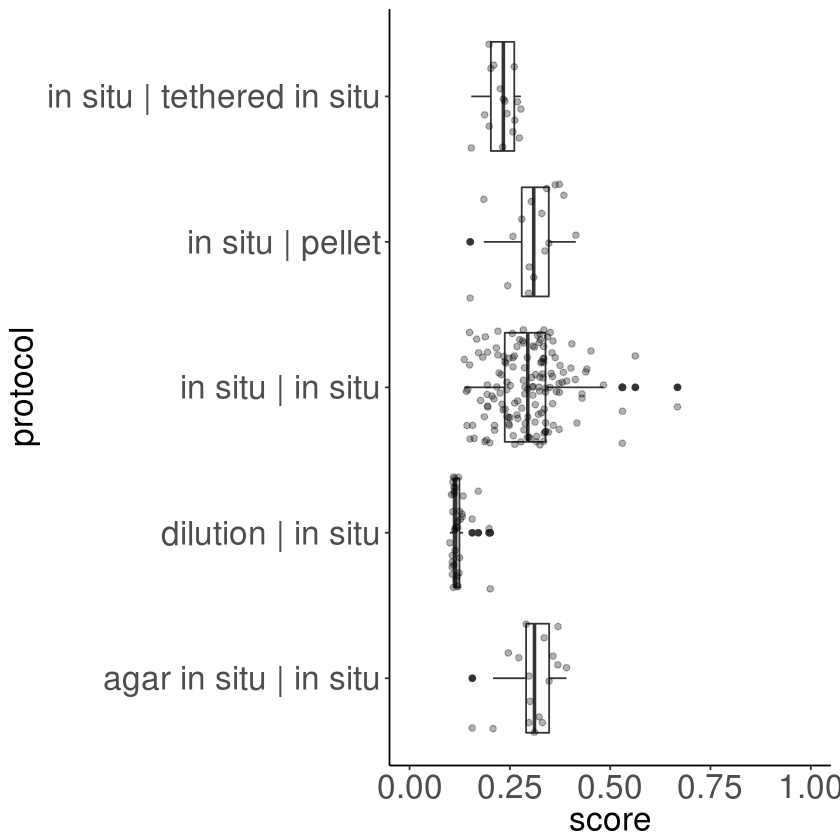

png 
  2

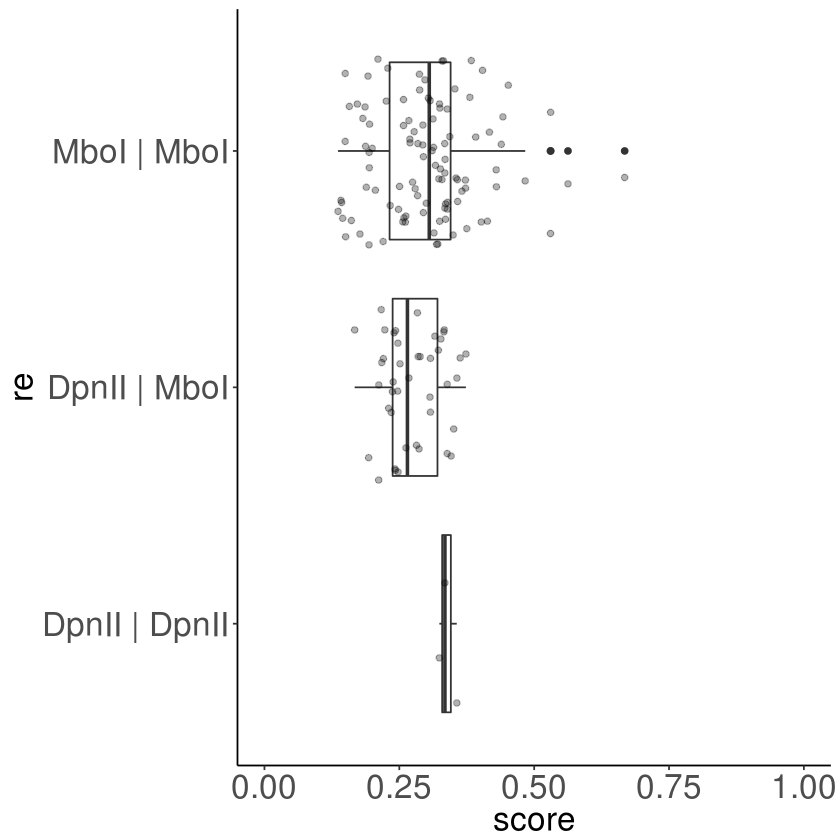

In [111]:
different_stuff=function(scores_orig,metadata,title,out){
    MINIMUM_COUNT=3
    WIDTH=10
    HEIGHT=15
    
    #fill in the entries from the metadata for the pairs
    scores=add_metadata(metadata,scores_orig)
    
    #specify which are bioreps and which experiments are done with the same restriction enzyme
    scores=annotate_biorep_re(scores)
    
    #keep only bioreps
    bioreps=which(as.character(scores[,'biorep'])=='1')
    scores=scores[bioreps,]
    
    colnames(scores)[3]='score'
    no_crosslink=which(grepl('NA',scores[,'crosslinking']))
    
    #remove no-crosslinking samples
    scores=scores[-no_crosslink,]
    
    ###############################
    ##### dilution vs in-situ #####
    ###############################
    scores=data.frame(scores,
                      protocol=paste(as.character(scores[,'protocol1']),'|',as.character(scores[,'protocol2'])),
                      stringsAsFactors=FALSE)
    for (i in c(1:(dim(scores)[1]))){
        protocols=c(as.character(scores[i,'protocol1']),as.character(scores[i,'protocol2']))
        protocols=protocols[order(protocols)]
        scores[i,'protocol']=paste(protocols[1],'|',protocols[2])
    }
    counts=table(scores[,'protocol'])
    keep=names(counts)[which(counts>=MINIMUM_COUNT)]
    protocol_scores=scores[which(as.character(scores[,'protocol']) %in% keep),]
    p=ggplot(protocol_scores,aes(y=score,x=protocol))+
    geom_boxplot()+geom_jitter(alpha=0.3)+theme_bw()+niceggplot+ #ylim(0,1)+
    coord_flip()+ylim(0,1)
    print(p)
    pdf(paste(out,'.',title,'.protocol.pdf',sep=''),width=8,height=5)
    print(p)
    dev.off()
    
    ###############################
    ##### restriction enzyme #####
    ###############################
    #for this, keep only in situ data
    in_situ=intersect(which(as.character(scores[,'protocol1'])=='in situ'),
                     which(as.character(scores[,'protocol2'])=='in situ'))
    scores=data.frame(scores,
                      re=paste(as.character(scores[,'re1']),'|',as.character(scores[,'re2'])),
                      stringsAsFactors=FALSE)
    scores=scores[in_situ,]
    for (i in c(1:(dim(scores)[1]))){
        res=c(as.character(scores[i,'re1']),as.character(scores[i,'re2']))
        res=res[order(res)]
        scores[i,'re']=paste(res[1],'|',res[2])
    }
    counts=table(scores[,'re'])
    keep=names(counts)[which(counts>=MINIMUM_COUNT)]
    re_scores=scores[which(as.character(scores[,'re']) %in% keep),]
    p=ggplot(re_scores,aes(y=score,x=re))+
    geom_boxplot()+geom_jitter(alpha=0.3)+theme_bw()+niceggplot+ #ylim(0,1)+
    coord_flip()+ylim(0,1)
    print(p)
    pdf(paste(out,'.',title,'.re.pdf',sep=''),width=6,height=4)
    print(p)
    dev.off()  

}

different_stuff(allscores[,c('m1','m2','GenomeDISCO')],test_data,'GenomeDISCO',
               paste(PLOTS_PATH,'/GenomeDISCO',sep=''))
different_stuff(allscores[,c('m1','m2','HiCRep')],test_data,'HiCRep',
               paste(PLOTS_PATH,'/HiCRep',sep=''))
different_stuff(allscores[,c('m1','m2','HiCSpector')],test_data,'HiC-Spector',
               paste(PLOTS_PATH,'/HiC-Spector',sep=''))

Make Supp Table 2

In [115]:
metadata_write=metadata[c(1:83),]

#add geo, data type, resolution
metadata_write=data.frame(GEO="GSE63525",
                          resolution=50000,
                          datatype="in situ Hi-C",
                            metadata_write)
write.table(metadata_write,
            file=paste(DATA_PATH,'/data/Supp_Table2.txt',sep=''),
           quote=FALSE,sep='\t',row.names=FALSE,col.names=TRUE)